# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

import matplotlib.pyplot as plt
import datetime
import time
import seaborn as sns
import pickle 
import re
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [3]:
# duplicate a dataframe to make clean dataset 
clean_portfolio = portfolio.copy()

In [4]:
# rename 'id' feature to 'offer_id' feature 
clean_portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [5]:
# use hot-encoding on the 'channel' column 
clean_portfolio['email'] = clean_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
clean_portfolio['mobile'] = clean_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
clean_portfolio['social'] = clean_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
clean_portfolio['web'] = clean_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [6]:
#change the duration from day to hour
clean_portfolio['duration'] = clean_portfolio['duration'] * 24

In [7]:
# make offer_type dataset according to offer_id
offer_type_df = portfolio[['id','offer_type']].rename(columns={'id':'offer_id'})

In [8]:
# get dummies of offer_type features
offer_type_dummies = pd.get_dummies(clean_portfolio['offer_type'], prefix='', prefix_sep='')

In [9]:
clean_portfolio = pd.concat([clean_portfolio, offer_type_dummies], axis=1, sort=False)

In [10]:
clean_portfolio

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,"[email, mobile, social]",10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,"[web, email, mobile, social]",10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,"[web, email, mobile]",0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,"[web, email, mobile]",5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,"[web, email]",20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,"[web, email, mobile, social]",7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,"[web, email, mobile, social]",10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,"[email, mobile, social]",0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,"[web, email, mobile, social]",5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,"[web, email, mobile]",10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [11]:
# initialize a scaler, then apply it to the features. 
scaler = MinMaxScaler()
numerical = ['difficulty','reward']

# features_log_minmax_transform = pd.DataFrame(data= features_log_transformed)
clean_portfolio[numerical] = scaler.fit_transform(clean_portfolio[numerical])

# Show an example of a record with scaling applied 
clean_portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id,email,mobile,social,web,bogo,discount,informational
0,1.0,"[email, mobile, social]",0.50,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,1.0,"[web, email, mobile, social]",0.50,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0.0,"[web, email, mobile]",0.00,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,0.5,"[web, email, mobile]",0.25,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,0.5,"[web, email]",1.00,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [12]:
# drop 'channels' and offer_type features
clean_portfolio.drop(columns=['channels','offer_type'], inplace=True)

In [13]:
clean_portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,1.0,0.50,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,1.0,0.50,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0.0,0.00,96,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,0.5,0.25,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,0.5,1.00,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,0.3,0.35,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,0.2,0.50,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0.0,0.00,72,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,0.5,0.25,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,0.2,0.50,168,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


## Preprocessing Profile dataset

In [14]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [15]:
# duplicate 'profile' dataframe to make clean dataset
clean_profile = profile.copy()

In [16]:
# renaming 'id' column name to 'customer_id'
clean_profile.rename(columns={'id':'customer_id'}, inplace=True)
clean_profile

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [17]:
clean_profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [18]:
# Preprocessing 'age' Feature 
# replace the age == 118 by Nan value

clean_profile['age'] = clean_profile['age'].apply(lambda x: np.nan if x== 118 else x)

In [19]:
# checking if there is 'age' == 118 value
clean_profile[clean_profile['age'] == 118]

,gender,age,customer_id,became_member_on,income


In [20]:
# drop any Nan value 
clean_profile.dropna(how='any', inplace=True)

In [21]:
# checking that the missing value have been successfully dropped 
clean_profile.isna().sum()

gender              0
age                 0
customer_id         0
became_member_on    0
income              0
dtype: int64

In [22]:
# checking 'gender' feature 
clean_profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

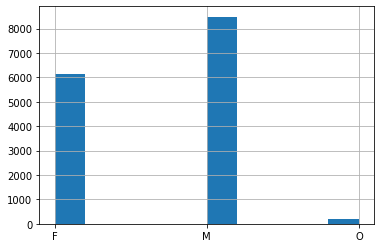

In [23]:
clean_profile['gender'].hist()

In [24]:
# changing the datatype of 'age' and 'income' feature to 'int'
clean_profile[['age','income']] = clean_profile[['age','income']].astype(int)

In [26]:
# Convert fetaure 'age' into 'age_by_decade' which would be helpful in determining if a particular age 
#is influenced more by an offer
clean_profile['age_by_decade'] = pd.cut(clean_profile['age'], bins=range(10,120,10),right=False, labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s', '90s', '100s'])

In [27]:
# checking the unique values in the new column 'age_group'
clean_profile['age_by_decade']

1        50s
3        70s
5        60s
8        60s
12       50s
        ... 
16995    40s
16996    60s
16997    40s
16998    80s
16999    60s
Name: age_by_decade, Length: 14825, dtype: category
Categories (10, object): [10s < 20s < 30s < 40s ... 70s < 80s < 90s < 100s]

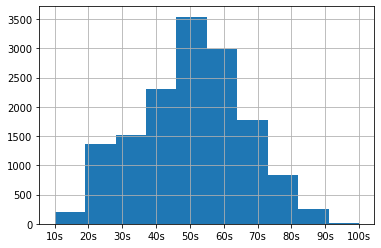

In [28]:
clean_profile['age_by_decade'].sort_values(ascending=True).hist()

In [29]:
# Preprocessing 'income' feature 
# first, we get to understand 'income' feature 
clean_profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [31]:
# Convert feature 'income' into 'income_by_range' which would be helpful in determining
# if a particular income range is influenced more by an offer
clean_profile['income_by_range'] = pd.cut(clean_profile['income'], bins=range(30000,140000,10000), right=False,\
                                    labels=['30ths','40ths', '50ths', '60ths', '70ths','80ths', '90ths',\
                                            '100ths', '110ths', '120ths'])

In [32]:
# Preprocessing 'became_member_on' feature

# Convert type of feature 'became_member_on' to type Datetime
type(pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt)

pandas.core.indexes.accessors.DatetimeProperties

In [33]:
# create feature 'became_member_year' in which customer became member from feature 'became_member_on'

clean_profile['became_member_year'] = pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.year

# create feature 'became_member_month' in which customer became member ffrom feature 'became_member_on'

clean_profile['became_member_month'] = pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.month

# create feature 'became_member_day' in which customer became member from feature 'became_member_on'
clean_profile['became_member_day'] = pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.day

# create feature 'memberdays' in which the number of days since the user is a member of starbucks

clean_profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(clean_profile['became_member_on'], format='%Y%m%d').dt.date
clean_profile['memberdays'] = clean_profile['memberdays'].dt.days

Text(0.5, 1.0, 'How long did the customers become our members?')

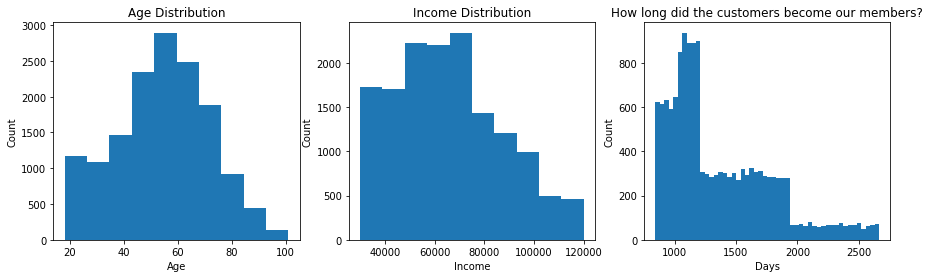

In [35]:
# to be able to draw three subplots in a row 
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)



# plot a age distribution
plt.sca(ax[0])
plt.hist(clean_profile['age'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')


# plot a income distribution 
plt.sca(ax[1])
plt.hist(clean_profile['income'])
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Income Distribution')


# display histogram of the days being member 
plt.sca(ax[2])
plt.hist(clean_profile['memberdays'], bins=50)
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('How long did the customers become our members?')

In [36]:
clean_profile

,gender,age,customer_id,became_member_on,income,age_by_decade,income_by_range,became_member_year,became_member_month,became_member_day,memberdays
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000,50s,110ths,2017,7,15,1220
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000,70s,100ths,2017,5,9,1287
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000,60s,70ths,2018,4,26,935
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000,60s,50ths,2018,2,9,1011
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000,50s,50ths,2017,11,11,1101
...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000,40s,50ths,2018,6,4,896
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000,60s,70ths,2018,7,13,857
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000,40s,70ths,2017,1,26,1390
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000,80s,50ths,2016,3,7,1715


In [37]:
# get dummies on feature 'gender','age_by_decade','income_by_range','year','month'


gender_dummies = pd.get_dummies(clean_profile['gender'], prefix='gender', prefix_sep='_')

age_dummies = pd.get_dummies(clean_profile['age_by_decade'], prefix='age',prefix_sep='_')

year_dummies = pd.get_dummies(clean_profile['became_member_year'], prefix='', prefix_sep='')

month_dummies = pd.get_dummies(clean_profile['became_member_month'], prefix='month', prefix_sep='_')

income_dummies = pd.get_dummies(clean_profile['income_by_range'], prefix='income', prefix_sep='_')

In [38]:
# combine the dataframe clean_profile with the differents dummies variables 
clean_profile = pd.concat([clean_profile, gender_dummies, age_dummies, year_dummies, month_dummies, income_dummies], axis=1, sort=False)

In [39]:
clean_profile

,gender,age,customer_id,became_member_on,income,age_by_decade,income_by_range,became_member_year,became_member_month,became_member_day,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000,50s,110ths,2017,7,15,...,0,0,0,0,0,0,0,0,1,0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000,70s,100ths,2017,5,9,...,0,0,0,0,0,0,0,1,0,0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000,60s,70ths,2018,4,26,...,0,0,0,0,1,0,0,0,0,0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000,60s,50ths,2018,2,9,...,0,0,1,0,0,0,0,0,0,0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000,50s,50ths,2017,11,11,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000,40s,50ths,2018,6,4,...,0,0,1,0,0,0,0,0,0,0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000,60s,70ths,2018,7,13,...,0,0,0,0,1,0,0,0,0,0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000,40s,70ths,2017,1,26,...,0,0,0,0,1,0,0,0,0,0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000,80s,50ths,2016,3,7,...,0,0,1,0,0,0,0,0,0,0


In [40]:
clean_profile.columns

Index(['gender', 'age', 'customer_id', 'became_member_on', 'income',
       'age_by_decade', 'income_by_range', 'became_member_year',
       'became_member_month', 'became_member_day', 'memberdays', 'gender_F',
       'gender_M', 'gender_O', 'age_10s', 'age_20s', 'age_30s', 'age_40s',
       'age_50s', 'age_60s', 'age_70s', 'age_80s', 'age_90s', 'age_100s',
       '2013', '2014', '2015', '2016', '2017', '2018', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'income_30ths',
       'income_40ths', 'income_50ths', 'income_60ths', 'income_70ths',
       'income_80ths', 'income_90ths', 'income_100ths', 'income_110ths',
       'income_120ths'],
      dtype='object')

## Preprocessing Transcript dataset

In [41]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [42]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [43]:
# duplicate transcript DataFrame for data cleaning-Wrangling

clean_transcript = transcript.copy()
clean_transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [44]:
# rename 'person' column to 'customer_id'

clean_transcript.rename(columns={'person':'customer_id'}, inplace=True)

In [45]:
# Data Cleaning the transcript dataframe

def get_offer_id(x):
    for key, value in x.items():
        if key in ['offer id','offer_id']:
            return str(value)
        
# Data Cleaning the transcript dataframe

def get_amount(x):
    for key, value in x.items():
        if key == 'amount':
            return str(value)

# get offer_id, amount, reward value from value column

clean_transcript['offer_id'] = clean_transcript['value'].apply(get_offer_id)
clean_transcript['amount'] = clean_transcript['value'].apply(get_amount)


# change amount column type to float
clean_transcript['amount'] = clean_transcript['amount'].astype('float')


# drop value column
clean_transcript.drop(columns=['value'], inplace=True)

In [46]:
clean_transcript

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53
306531,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,None,3.53


In [47]:
# transcript: drop transaction rows whose customer_id is not in profile: customer_id

clean_transcript = clean_transcript[clean_transcript['customer_id'].isin(clean_profile['customer_id'])]

In [48]:
# access the duplicate values 
clean_transcript.duplicated().sum()

374

In [49]:
# drop the duplicated value, and reset the index 
clean_transcript.drop_duplicates(inplace=True)

clean_transcript.reset_index(drop=True, inplace=True)

C:\Users\yng12\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [50]:
# checking 
clean_transcript[clean_transcript['customer_id'] == '78afa995795e4d85b5d9ceeca43f5fef']

,customer_id,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
13545,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
42328,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,None,19.89
42329,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
44065,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,None,17.78
47385,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN
75792,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,NaN
77440,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,None,19.67
81925,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,None,29.72
125790,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,None,23.93


In [51]:
# one-hot encoding offer event 

clean_transcript['completed'] = clean_transcript['event'].apply(lambda x:1 if x == 'offer completed' else 0)
clean_transcript['viewed'] = clean_transcript['event'].apply(lambda x:1 if x == 'offer viewed' else 0)
clean_transcript['received'] = clean_transcript['event'].apply(lambda x:1 if x== 'offer received' else 0)

C:\Users\yng12\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\yng12\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yng12\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [52]:
clean_transcript

,customer_id,event,time,offer_id,amount,completed,viewed,received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,1
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,0,1
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,1
...,...,...,...,...,...,...,...,...
272383,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0
272384,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,0,0
272385,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,0,0
272386,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,0,0


In [53]:
# Transcript; segregate offer and transaction data

# extract transactions from clean_transcript data

transaction_df = clean_transcript[clean_transcript['event'] == 'transaction'][['customer_id','time','amount']]
transaction_df

,customer_id,time,amount
11027,02c083884c7d45b39cc68e1314fec56c,0,0.83
11030,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
11032,54890f68699049c2a04d415abc25e717,0,13.23
11040,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
11041,fe97aa22dd3e48c8b143116a8403dd52,0,18.97
...,...,...,...
272382,24f56b5e1849462093931b164eb803b5,714,22.64
272384,b3a1272bc9904337b331bf348c3e8c17,714,1.59
272385,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53
272386,a00058cf10334a308c68e7631c529907,714,3.61


In [54]:
# transcript : segregate offer and transaction data 

# extract offer-related from clean_transcript data

offers_df = clean_transcript[clean_transcript['event'] != 'transaction']
offers_df.drop(columns=['event','amount'], inplace=True)
offers_df

C:\Users\yng12\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,customer_id,time,offer_id,completed,viewed,received
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0,1
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0,1
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0,1
3,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1
...,...,...,...,...,...,...
272343,84fb57a7fe8045a8bf6236738ee73a0f,714,5a8bc65990b245e5a138643cd4eb9837,0,1,0
272350,abc4359eb34e4e2ca2349da2ddf771b6,714,3f207df678b143eea3cee63160fa8bed,0,1,0
272363,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
272365,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0


In [55]:
clean_transcript

,customer_id,event,time,offer_id,amount,completed,viewed,received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1
1,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,1
2,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,0,1
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,NaN,0,0,1
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,1
...,...,...,...,...,...,...,...,...
272383,24f56b5e1849462093931b164eb803b5,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0
272384,b3a1272bc9904337b331bf348c3e8c17,transaction,714,None,1.59,0,0,0
272385,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,None,9.53,0,0,0
272386,a00058cf10334a308c68e7631c529907,transaction,714,None,3.61,0,0,0


In [56]:
# value_counts completed 

offer_completed_df = clean_transcript[clean_transcript['completed'] == 1]
offer_completed_df

,customer_id,event,time,offer_id,amount,completed,viewed,received
11031,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0
11042,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0
11048,629fc02d56414d91bca360decdfa9288,offer completed,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0
11056,676506bad68e4161b9bbaffeb039626b,offer completed,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1,0,0
11060,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0
...,...,...,...,...,...,...,...,...
272319,f3e801caeafe4899b3b989b586e74ac7,offer completed,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0
272331,452cdae2c68e4732a4177d3929562690,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0
272336,0c027f5f34dd4b9eba0a25785c611273,offer completed,714,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,1,0,0
272365,8431c16f8e1d440880db371a68f82dd0,offer completed,714,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0


In [57]:
offer_completed_df['offer_id'].value_counts()

fafdcd668e3743c1bb461111dcafc2a4    4957
2298d6c36e964ae4a3e7e9706d1fb8c2    4847
9b98b8c7a33c4b65b9aebfe6a799e6d9    4141
f19421c1d4aa40978ebb69ca19b0e20d    4074
2906b810c7d4411798c6938adc9daaa5    3860
ae264e3637204a6fb9bb56bc8210ddfd    3604
0b1e1539f2cc45b7b9fa7c272da2e1d7    3306
4d5c57ea9a6940dd891ad53e9dbe8da0    3281
Name: offer_id, dtype: int64

## Combine data
    - offer dataframe 
    - transaction dataframe
    - clean_profile dataframe
    

In [56]:
def combine_data(clean_profile, clean_portfolio, offer_df, transaction_df):
    
    data = []
    customer_ids = offers_df['customer_id'].unique()
    
    
    # loop through all customer ids in offers_df
    for ind in range(len(customer_ids)):
        
        # get customer id from the list 
        cust_id = customer_ids[ind]
        
        # extract customer profile from clean_profile data
        customer = clean_profile[clean_profile['customer_id'] == cust_id]
        
        # extract offers related to customer from offers_df
        cust_offer_data = offers_df[offers_df['customer_id'] == cust_id]
        
        # extract transactions relatedt to the customer from transaction_df
        cust_transaction_data = transaction_df[transaction_df['customer_id'] == cust_id]
        
        # extract received, completed, viewed offer data from customer offfers
        offer_received_data = cust_offer_data[cust_offer_data['received'] ==1]
        offer_completed_data = cust_offer_data[cust_offer_data['completed'] == 1]
        offer_viewed_data = cust_offer_data[cust_offer_data['viewed'] ==1]
        
        rows = []
        
        # loop through each received offer
        
        for i in range(offer_received_data.shape[0]):
            
            # offer_id
            offer_id = offer_received_data.iloc[i]['offer_id']
            
            # extract offer row from clean_portfolio
            offer_row = clean_portfolio.loc[clean_portfolio['offer_id'] == offer_id]
            
            # extract duration days of an offer from offer row
            duration = offer_row['duration'].values[0]
            
            #initialize start and end time of an offer
            start_time = offer_received_data.iloc[i]['time']
            end_time = start_time + duration
            
            # segregate offers completed within end date
            offer_completed_intime = np.logical_and(offer_completed_data['time'] >= start_time,
                                              offer_completed_data['time'] <= end_time)
            # segregate offers viewed within end date
            offer_viewed_intime = np.logical_and(offer_viewed_data['time'] >= start_time,
                                                offer_viewed_data['time'] <= end_time)
            
            #flag offer_successful to 1 if an offer is viewed and compelted within end time else to 0
            offer_success = offer_completed_intime.sum() > 0 
            
            # extract transactions occured within time
            transaction_intime = np.logical_and(cust_transaction_data['time'] >= start_time,
                                               cust_transaction_data['time'] <= end_time)
            
            transaction_data = cust_transaction_data[transaction_intime]
            
            # total amount spent by a customer from given offers
            transaction_total_amount = transaction_data['amount'].sum()
            
            row = {
                'offer_id': offer_id,
                'customer_id': cust_id,
                'time': start_time,
                'total_amount': transaction_total_amount,
                'offer_success': int(offer_success),
            }
            
            row.update(offer_row.iloc[0,0:].to_dict())
            
            row.update(customer.iloc[0,:].to_dict())
            
            rows.append(row)
            
        data.extend(rows)
        
    data = pd.DataFrame(data)
    
    return data

In [57]:
merged_df = combine_data(clean_profile, clean_portfolio, offers_df, transaction_df)

100% (14820 of 14820) |##################| Elapsed Time: 0:10:51 Time:  0:10:51


In [57]:
merged_df

NameError: name 'merged_df' is not defined

In [58]:
merged_df['offer_success'].value_counts()

NameError: name 'merged_df' is not defined

In [60]:
merged_df.to_csv('merged_df.csv', index=False)

NameError: name 'merged_df' is not defined

In [58]:
df = pd.read_csv('merged_df.csv')

In [59]:
df

,offer_id,customer_id,time,total_amount,offer_success,reward,difficulty,duration,email,mobile,...,income_30ths,income_40ths,income_50ths,income_60ths,income_70ths,income_80ths,income_90ths,income_100ths,income_110ths,income_120ths
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,0,37.67,1,0.5,0.25,168,1,1,...,0,0,0,0,0,0,0,1,0,0
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,168,49.39,0,0.0,0.00,72,1,1,...,0,0,0,0,0,0,0,1,0,0
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,408,48.28,1,1.0,0.50,168,1,1,...,0,0,0,0,0,0,0,1,0,0
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,504,48.28,1,0.5,0.25,120,1,1,...,0,0,0,0,0,0,0,1,0,0
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,0,0.00,0,0.2,0.50,168,1,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,2906b810c7d4411798c6938adc9daaa5,3cc622f76e464bc1809a71e871579d6c,576,34.04,1,0.2,0.50,168,1,1,...,0,1,0,0,0,0,0,0,0,0
66497,5a8bc65990b245e5a138643cd4eb9837,01fe5ec668f241608eb2f7ec374cb1b7,576,19.92,0,0.0,0.00,72,1,1,...,0,0,0,1,0,0,0,0,0,0
66498,9b98b8c7a33c4b65b9aebfe6a799e6d9,d825b707198046e39baa4fdcfa11d621,576,28.42,1,0.5,0.25,168,1,1,...,0,0,0,0,1,0,0,0,0,0
66499,2298d6c36e964ae4a3e7e9706d1fb8c2,c207a8a8ef5c47ee970ca45f859e07eb,576,75.84,1,0.3,0.35,168,1,1,...,0,0,0,0,0,1,0,0,0,0


In [60]:
df.columns

Index(['offer_id', 'customer_id', 'time', 'total_amount', 'offer_success',
       'reward', 'difficulty', 'duration', 'email', 'mobile', 'social', 'web',
       'bogo', 'discount', 'informational', 'gender', 'age',
       'became_member_on', 'income', 'age_by_decade', 'income_by_range',
       'became_member_year', 'became_member_month', 'became_member_day',
       'memberdays', 'gender_F', 'gender_M', 'gender_O', 'age_10s', 'age_20s',
       'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_80s',
       'age_90s', 'age_100s', '2013', '2014', '2015', '2016', '2017', '2018',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'income_30ths', 'income_40ths', 'income_50ths', 'income_60ths',
       'income_70ths', 'income_80ths', 'income_90ths', 'income_100ths',
       'income_110ths', 'income_120ths'],
      dtype='object')

## data analysis 

- i want to know which offer is most successful between offers and offer types.


In [61]:
def calculate_percentage_success():
    
    
    # calculate count according to each offer_id
    offer_count = df.groupby(['offer_id'])['offer_success'].count().reset_index()
    offer_count.rename(columns={'offer_success':'count'}, inplace=True)
    
    # calculate count of offer_success according to each offer_id
    success_count = df.groupby(['offer_id'])['offer_success'].sum().reset_index()
    
    # create dataframe related to dataset to get percentage of offer_success
    percent_df = pd.merge(offer_count, success_count, on='offer_id')
    
    # calculate percentage of success
    percent_df['percentage_success'] = (100 * percent_df['offer_success'] / percent_df['count'])
    
    percent_df.drop(columns={'offer_success'}, inplace=True)
    
    percent_df = percent_df.sort_values('percentage_success', ascending=False)
    
    # make offer_type column to better understand between offer_type
    offer_type_df = portfolio[['id','offer_type']].rename(columns={'id':'offer_id'})
    
    # merge offer_type_df and percent_df 
    percent_df_merged = pd.merge(percent_df, offer_type_df, on='offer_id')
    
    
    return percent_df_merged.reset_index()

In [62]:
percentage_df = calculate_percentage_success()
percentage_df

,index,offer_id,count,percentage_success,offer_type
0,0,fafdcd668e3743c1bb461111dcafc2a4,6652,75.841852,discount
1,1,2298d6c36e964ae4a3e7e9706d1fb8c2,6655,73.658903,discount
2,2,9b98b8c7a33c4b65b9aebfe6a799e6d9,6685,63.066567,bogo
3,3,f19421c1d4aa40978ebb69ca19b0e20d,6576,62.940998,bogo
4,4,2906b810c7d4411798c6938adc9daaa5,6631,59.885387,discount
5,5,ae264e3637204a6fb9bb56bc8210ddfd,6683,58.401915,bogo
6,6,0b1e1539f2cc45b7b9fa7c272da2e1d7,6726,56.497175,discount
7,7,4d5c57ea9a6940dd891ad53e9dbe8da0,6593,52.874261,bogo
8,8,3f207df678b143eea3cee63160fa8bed,6657,10.830705,informational
9,9,5a8bc65990b245e5a138643cd4eb9837,6643,7.571880,informational


Text(0, 0.5, 'Count')

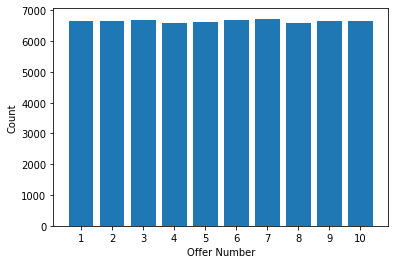

In [63]:
# visualize count per offer_id 
plt.bar(percentage_df.index+1, percentage_df['count'])
plt.xticks(np.arange(0,10) +1)
plt.xlabel('Offer Number')
plt.ylabel('Count')

Text(0.5, 1.0, 'offer Success rate per offer_type')

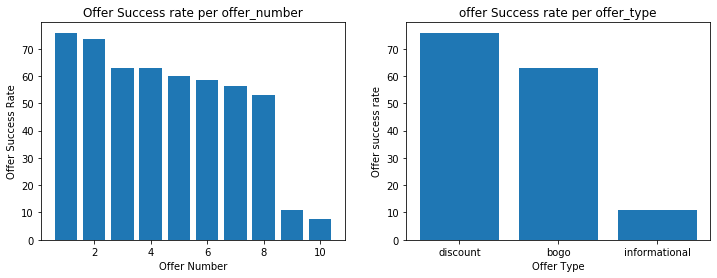

In [64]:
# visualize success percentage of offer between offer_id and offer_type 
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# Offer Success rate per offer_number 
plt.sca(ax[0])
plt.bar(percentage_df.index+1,percentage_df['percentage_success'])
plt.xlabel('Offer Number')
plt.ylabel('Offer Success Rate')
plt.title('Offer Success rate per offer_number')

# offer Success rate per offer_type
plt.sca(ax[1])
plt.bar(percentage_df['offer_type'], percentage_df['percentage_success'])
plt.xlabel('Offer Type')
plt.ylabel('Offer success rate')
plt.title('offer Success rate per offer_type')

In [65]:
# calculate total_amount by offer_id
amount_df = df.groupby(['offer_id'])['total_amount'].sum().sort_values(ascending=False).reset_index()
amount_df

,offer_id,total_amount
0,fafdcd668e3743c1bb461111dcafc2a4,351533.28
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,247704.98
2,2298d6c36e964ae4a3e7e9706d1fb8c2,246044.98
3,ae264e3637204a6fb9bb56bc8210ddfd,234515.80
4,2906b810c7d4411798c6938adc9daaa5,198311.54
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,192549.06
6,4d5c57ea9a6940dd891ad53e9dbe8da0,183668.11
7,f19421c1d4aa40978ebb69ca19b0e20d,179603.67
8,3f207df678b143eea3cee63160fa8bed,106239.36
9,5a8bc65990b245e5a138643cd4eb9837,98777.65


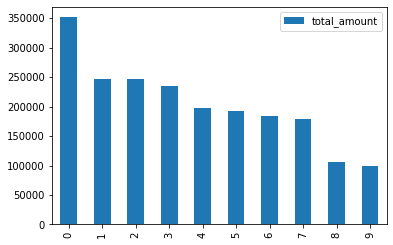

In [66]:
# visualize total_amount to each offer_id 
amount_df.plot(kind='bar')

In [67]:
# add offer_type column 
amount_df_merged = pd.merge(amount_df, offer_type_df, on='offer_id')
amount_df_merged

,offer_id,total_amount,offer_type
0,fafdcd668e3743c1bb461111dcafc2a4,351533.28,discount
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,247704.98,discount
2,2298d6c36e964ae4a3e7e9706d1fb8c2,246044.98,discount
3,ae264e3637204a6fb9bb56bc8210ddfd,234515.80,bogo
4,2906b810c7d4411798c6938adc9daaa5,198311.54,discount
5,9b98b8c7a33c4b65b9aebfe6a799e6d9,192549.06,bogo
6,4d5c57ea9a6940dd891ad53e9dbe8da0,183668.11,bogo
7,f19421c1d4aa40978ebb69ca19b0e20d,179603.67,bogo
8,3f207df678b143eea3cee63160fa8bed,106239.36,informational
9,5a8bc65990b245e5a138643cd4eb9837,98777.65,informational


In [68]:
# Calculate total_amount by different offer type
amount_df_merged.groupby(['offer_type'])['total_amount'].sum().sort_values(ascending=False)

offer_type
discount         1043594.78
bogo              790336.64
informational     205017.01
Name: total_amount, dtype: float64

In [69]:
# Calculate total_amount by different offer type
amount_by_type = amount_df_merged.groupby(['offer_type'])['total_amount'].sum().sort_values(ascending=False)

In [70]:
amount_by_type

offer_type
discount         1043594.78
bogo              790336.64
informational     205017.01
Name: total_amount, dtype: float64

Text(0.5, 1.0, 'Total amunt spent by offer type')

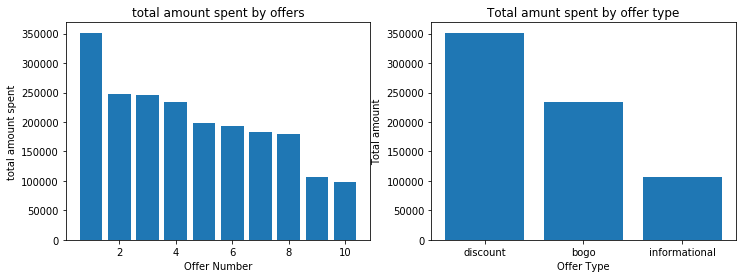

In [71]:
# visualization
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)

# total amount spent by offer_id
plt.sca(ax[0])
plt.bar(amount_df.index+1, amount_df['total_amount'])
plt.xlabel('Offer Number')
plt.ylabel('total amount spent')
plt.title('total amount spent by offers')

# total amount spent by offer_type
plt.sca(ax[1])
plt.bar(amount_df_merged['offer_type'],amount_df_merged['total_amount'])
plt.xlabel('Offer Type')
plt.ylabel('Total amount')
plt.title('Total amunt spent by offer type')

## Build models

### Create train and test datasets


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66501 entries, 0 to 66500
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   offer_id             66501 non-null  object 
 1   customer_id          66501 non-null  object 
 2   time                 66501 non-null  int64  
 3   total_amount         66501 non-null  float64
 4   offer_success        66501 non-null  int64  
 5   reward               66501 non-null  float64
 6   difficulty           66501 non-null  float64
 7   duration             66501 non-null  int64  
 8   email                66501 non-null  int64  
 9   mobile               66501 non-null  int64  
 10  social               66501 non-null  int64  
 11  web                  66501 non-null  int64  
 12  bogo                 66501 non-null  int64  
 13  discount             66501 non-null  int64  
 14  informational        66501 non-null  int64  
 15  gender               66501 non-null 

In [73]:
# drop features from df which are not required for training the model
df.drop(columns=['customer_id','offer_id','time','gender','age_by_decade','income_by_range'], inplace=True)

In [74]:
# Split data into features X and target y
X = df.drop(columns=['offer_success'])

#target
y = df['offer_success']

In [75]:
# split data into train and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

In [76]:
# train_data : extract offer_id, total_amount and convert other features to float
X_train = X_train.astype('float64')

# test_data: extract offer_id, total_amount and convert other features to float
X_test = X_test.astype('float64')

### Scale features

In [77]:
# initialize a scaler, then apply it to the features 
scaler = MinMaxScaler()
# Prepare list of features to scale 
features_to_scale = ['difficulty', 'duration','memberdays','total_amount']

df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

### Naive_bayes Classifier

In [78]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer

In [80]:
naive_clf = GaussianNB()

naive_clf.fit(X_train, y_train)

y_pred = naive_clf.predict(X_test)
naive_clf_accuracy = accuracy_score(y_pred, y_test)
naive_clf_f1score = f1_score(y_pred, y_test)

print(classification_report(y_pred, y_test,target_names=['offer_failed','offer_succeed']))
print("Naive Predictor accuracy:", naive_clf_accuracy)
print("Naive predictor f1-score:", naive_clf_f1score)

               precision    recall  f1-score   support

 offer_failed       0.87      0.72      0.78     11414
offer_succeed       0.69      0.85      0.76      8537

     accuracy                           0.78     19951
    macro avg       0.78      0.79      0.77     19951
 weighted avg       0.79      0.78      0.78     19951

Naive Predictor accuracy: 0.775199238133427
Naive predictor f1-score: 0.7646287063762792


### Logistic Regression Model

In [84]:
# instantiate a logistic regression
log_reg = LogisticRegression()

scorer = make_scorer(fbeta_score, beta=0.5)



# construct a params dict to tune the model
random_grid = {
    'penalty': ['l1','l2'],
    'C': [1.0, 0.1, 0.01]
}

log_reg_random = RandomizedSearchCV(log_reg, param_distributions = random_grid,
                                   scoring=scorer, n_iter=6, cv=3, verbose=2,
                                   random_state=42, n_jobs=3)

# fit train data to the model 
log_reg_random.fit(X_train, y_train)

# predict test data
y_pred = log_reg_random.best_estimator_.predict(X_test)

log_reg_accuracy = accuracy_score(y_pred, y_test)
log_reg_f1score = f1_score(y_pred, y_test)


# display the  model results
print(classification_report(y_pred, y_test,target_names=['offer_failed','offer_succeed']))
print("Logistic Regression model's accuracy is:", log_reg_accuracy)
print("Logistic Regression model's accuracy is:", log_reg_f1score)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  18 out of  18 | elapsed:    1.7s finished


               precision    recall  f1-score   support

 offer_failed       0.61      0.60      0.60      9549
offer_succeed       0.64      0.64      0.64     10402

     accuracy                           0.62     19951
    macro avg       0.62      0.62      0.62     19951
 weighted avg       0.62      0.62      0.62     19951

Logistic Regression model's accuracy is: 0.6225753095082953
Logistic Regression model's accuracy is: 0.640057361376673


### Random Forest Classifier Model

In [85]:
n_estimators =[10, 50, 100, 150, 200, 250, 300]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in range(2, 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

scorer = make_scorer(fbeta_score, beta=0.5)

# instantiate a RandomForestClassifier
rf = RandomForestClassifier()


# construct a params dict to tune the model
random_grid = {'n_estimators': n_estimators,
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(rf, param_distributions = random_grid,
                               n_iter=50, cv=2, scoring=scorer,
                               verbose=2, n_jobs=4, random_state=42)

# fit train data to the model
rf_random.fit(X_train, y_train)

# predict test data
y_pred  = rf_random.best_estimator_.predict(X_test)

rf_accuracy = accuracy_score(y_pred, y_test)
rf_f1score = f1_score(y_pred, y_test)

# display the results
print(classification_report(y_pred, y_test,target_names=['offer_failed','offer_succeed']))
print("Random Forest Classifier Model's accuracy is :", rf_accuracy)
print("Random Forest Classifier Model's f1 score is:", rf_f1score)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   26.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.3min finished


               precision    recall  f1-score   support

 offer_failed       0.95      0.93      0.94      9636
offer_succeed       0.93      0.95      0.94     10315

     accuracy                           0.94     19951
    macro avg       0.94      0.94      0.94     19951
 weighted avg       0.94      0.94      0.94     19951

Random Forest Classifier Model's accuracy is : 0.9389003057490852
Random Forest Classifier Model's f1 score is: 0.9414870637930206


## Results 

Results suggest that a random forest model's performance is better than 
   naive bayes classifier and Logistic Regression model.
   
 - Accuracy
     - Naive bayes classifier: 0.77
     - Logistic Regression: 0.62
     - Random Forest Classifier: 0.94
 - F1-score
     - Naive bayes classifier:0.76
     - Logistic Regression:0.64
     - Random Forest Classifier:0.94

## Conclusion

The goal of this project is to predict how the customer will respond to an offer through predictive model. First, I planned to combine offer portfolio dataset, customer profile dataset and transaction dataset with data-cleaning. Second, I created train-test datasets after scaling and turning combined datasets into numerical data. Third, I built three predictive models(Naive Bayes classifier, Logistic Regression, Random Forest Classifer) to calculate the accuracy and f1-score. Then, I compared the performance of three models. As a result, Random Forest Classifier model has highest accuracy and f1-score with Randomized Search CV.